<a href="https://colab.research.google.com/github/zahraa-elhareedy/Face_Recognition/blob/main/Face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [1]:
from sklearn import metrics
import os
import numpy as np
from PIL import Image
from zipfile import ZipFile
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import accuracy_score
from collections import Counter
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from sklearn import metrics
import time

Unzipping

In [8]:

folder_name = '/archive.zip'
with ZipFile(folder_name, 'r') as zip:
  zip.extractall('/dataset')



Generate the Data Matrix and the Label vector

In [9]:
subjects_no = 40
images_per_subject = 10
width = 92
height = 112
D = np.empty([subjects_no * images_per_subject , width * height])
y = np.empty(subjects_no * images_per_subject)
for i in range(1,subjects_no+1) : #loop on each subject inside main folder
  for j in range(1,images_per_subject+1): #loop for each image in each subject
            image_path = os.path.join('/dataset', f's{i}', f'{j}.pgm')
            image = Image.open(image_path)
            #np.array(image).shape gives (112 , 92) which are the dimensions of each image
            image_vector = np.array(image).reshape(-1) #convert it into 1D
            #len(image_vector) gives 10304 which is 92 x 112
            D[(i-1)*images_per_subject+(j-1) ,: ] = image_vector
            y[(i-1)*images_per_subject+(j-1) ] = i

print(f'Data Matrix D shape: {D.shape}')
print(f'Label vector y shape: {y.shape}')

Data Matrix D shape: (400, 10304)
Label vector y shape: (400,)


In [10]:
def split_data(D,y,training_set_indices,testing_set_indices):
  training_set = D[training_set_indices]
  testing_set = D[testing_set_indices]
  training_labels = y[training_set_indices] 
  testing_labels = y[testing_set_indices] 
  print(training_set)
  print(testing_set.shape)
  print(testing_labels.shape)
  print(training_labels.shape)
  return training_set, testing_set, training_labels, testing_labels 

Find First Occurence

In [11]:
def find_first_occurrence(neighbor_labels, max_elements):
    for elem in neighbor_labels:
        if elem in max_elements:
            return elem
    return None

Voting

In [12]:
def voting(neighbor_label):
  winning_labels = []
  for row in neighbor_label:
    counts = Counter(row)
    # Find the elements with the highest count
    max_count = 0
    max_elements = []
    for element, count in counts.items():
        if count > max_count:
            max_count = count
            max_elements = [element]
        elif count == max_count:
            max_elements.append(element)
    if len(max_elements) > 1 :
      max_elements = [find_first_occurrence(row,max_elements)]
    winning_labels.append(max_elements)
  return winning_labels  

KNN

In [13]:
def KNN(k, projected_test, projected_train,training_labels,testing_labels,faces_nf_test=[],faces_nf_train=[]):
  euclidean_distance = euclidean_distances(projected_test,projected_train)
  neighbor_index = np.argsort(euclidean_distance)[:,0:k]
  neighbor_label = training_labels[neighbor_index]
  accuracy = accuracy_score(testing_labels,neighbor_label)
  if k != 1:
    neighbor_label = voting(neighbor_label)   
  if testing_labels[0] == 1: # faces dataset
    test_against_neighbor(testing_labels,neighbor_label,testing_set,training_set,neighbor_index)
  if testing_labels[0] == 0: # face vs non face dataset
    confusion_matrix = metrics.confusion_matrix(testing_labels,neighbor_label)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
    cm_display.plot()
    plt.show()
    show_success_failure(testing_labels,neighbor_label,faces_nf_test,faces_nf_train,neighbor_index)  
  return accuracy*100

Classification using PCA

In [14]:
def PCA(training_set):
  mean_vector = training_set.mean(axis=0)
  Z = training_set - mean_vector #centralize data
  Z_t = np.transpose(Z)
  cov_matrix = np.dot(Z_t,Z)/training_set.shape[0]
  eigen_values, U = np.linalg.eigh(cov_matrix)
  indices = np.argsort(eigen_values)[::-1] #sort descendingly 
  eigen_values_vector = eigen_values[indices] 
  eigen_values = np.diag(eigen_values_vector)
  U = U[:,indices]
  print(U.shape)
  print(eigen_values.shape)
  verified = np.dot(U,eigen_values)
  verified = np.dot(verified,np.transpose(U))
  print(np.allclose(cov_matrix, verified, rtol=1e-3, atol=1e-3)) #check if verified maps back to D
  return U , Z , eigen_values

LDA

In [15]:
def LDA(training_set,training_labels,subjects_no,width,height,eigen_vector_no):
  total_mean = training_set.mean(axis=0)  
  Sb = np.zeros((width*height,width*height))
  S = np.zeros((width*height,width*height))
  class_mean = np.empty([subjects_no,width*height])
  for id in range(1,subjects_no+1):
    class_matrix = training_set[training_labels == id ]  #select data in this class 
    samples_no_per_class = class_matrix.shape[0]
    class_mean[id-1] = class_matrix.mean(axis=0)

    class_Z = class_matrix - class_mean[id-1]
    class_Z_transpose = np.transpose(class_Z)
    Si = np.dot(class_Z_transpose,class_Z)
    S = S + Si
    mean_diff = (class_mean[id-1] - total_mean).reshape(width*height,1)
    mean_diff_transpose = np.transpose(mean_diff)
    Sb = Sb + samples_no_per_class * np.dot(mean_diff,mean_diff_transpose)

  S_inv = np.linalg.inv(S)
  S_inv_Sb = np.dot(S_inv,Sb)
  lamda_eigen_values, w = np.linalg.eigh(S_inv_Sb)
  lamda_indices = np.argsort(lamda_eigen_values)[::-1] #sort descendingly 
  lamda_eigen_values_sorted = lamda_eigen_values[lamda_indices] 
  w = w[lamda_indices]
  print(w.shape)
  U_lda = w[:,0:eigen_vector_no]
  return U_lda

Choosing Dimensions

In [16]:
def dimensions( alpha, eigen_values):
  r = 0 #dimensions
  explained_variance = 0
  sum = np.sum(eigen_values) #get total 
  for value in eigen_values :
    explained_variance = explained_variance + value[r] #each time add a value
    r = r + 1
    if ((explained_variance / sum) >= alpha): #check if threshold is reached
      break
  return r


In [17]:
def Prepare_non_faces(train_nf, test_nf) :
  # Convert the color images to grayscale and resize to 92x112
  train_non_faces = []
  for img in train_nf:
      pil_img = Image.fromarray(img).convert('L').resize((92, 112)) #convert to gray images with size 92*112 
      gray_img = np.array(pil_img.getdata()).reshape((112, 92))
      gray_img_vector = np.array(gray_img).reshape(-1) # convert to a 1-D vector
      train_non_faces.append(gray_img_vector)
  train_non_faces = np.array(train_non_faces)

  test_non_faces = []
  for img in test_nf:
      pil_img = Image.fromarray(img).convert('L').resize((92, 112))
      gray_img = np.array(pil_img.getdata()).reshape((112, 92))
      gray_img_vector = np.array(gray_img).reshape(-1)
      test_non_faces.append(gray_img_vector)
      
  test_non_faces = np.array(test_non_faces)
  return train_non_faces,test_non_faces

In [18]:
def binary_LDA(faces_nf_train,train_labels_f_nf):
  class_non_faces = faces_nf_train[train_labels_f_nf == 0 ]  #select data in this class
  class_faces = faces_nf_train[train_labels_f_nf == 1 ]  #select data in this class
  Mean1=class_non_faces.mean(axis=0)
  Mean2=class_faces.mean(axis=0)
  B=(Mean1-Mean2).reshape(width*height,1)
  B_t=np.transpose(B)
  print(B.shape)
  SB=[]
  SB=np.dot(B,B_t)
  print(SB.shape)

  class_non_faces_centred= class_non_faces - Mean1
  class_non_faces_t = np.transpose(class_non_faces_centred)
  class_faces_centred= class_faces - Mean2
  class_faces_t = np.transpose(class_faces_centred)
  S1 = np.dot(class_non_faces_t,class_non_faces_centred)
  S2 = np.dot(class_faces_t,class_faces_centred) 
  SW = S1 + S2
  SW_inv = np.linalg.inv(SW)
  test= np.dot(SW_inv,SB)
  eigen_values,eigen_vector=np.linalg.eigh(test)
  indeces=np.argsort(eigen_values)[::-1] 
  eigen_values=eigen_values[indeces] 
  eigen_vector=eigen_vector[:,indeces]
  print(eigen_values.shape)
  print(eigen_vector.shape)
  return eigen_values,eigen_vector

In [19]:
def display_photos(index,testing_set,training_set,neighbor_index,testing_label,neighbor_label):
  face_nf_image_train=np.array(training_set[neighbor_index]).reshape(112,92)
  img_train = Image.fromarray( face_nf_image_train)
  face_nf_image_test=np.array(testing_set[index]).reshape(112,92)
  img_test = Image.fromarray( face_nf_image_test)
  # Display the image
  print("training")
  print(neighbor_label)
  img_train.show()
  print("testing")
  print(testing_label)
  img_test.show()


In [3]:
def test_against_neighbor(testing_labels,neighbor_labels,testing_set,training_set,neighbor_indices):
  counter =0
  while counter < 3 :
    random_index = np.random.choice(testing_labels.shape[0], 1, replace=False) 
    neighbor_index = neighbor_indices[random_index]
    if testing_labels[random_index] == neighbor_labels[random_index]:
      print("This face is correctly classified to its class")
      display_photos(random_index,testing_set,training_set,neighbor_index,testing_labels[random_index],neighbor_labels[random_index])
      print("-------------------------------------")
    elif testing_labels[random_index] != neighbor_labels[random_index]:
      print("This face is incorrectly classified to a wrong class")
      display_photos(random_index,testing_set,training_set,neighbor_index,testing_labels[random_index],neighbor_labels[random_index])
      print("-------------------------------------")
    counter = counter + 1

In [4]:
def show_success_failure(testing_labels,neighbor_labels,testing_set,training_set,neighbor_indices):
  tp = 0
  tn = 0
  fp = 0
  fn = 0
  counter = 0
  while (not(tp and tn and fp and fn)) and counter < 100:
    random_index = np.random.choice(testing_labels.shape[0], 1, replace=False) 
    if testing_labels[random_index] == neighbor_labels[random_index]:
      if testing_labels[random_index] == 1 and tp ==0 : # correctly classified as faces
        tp = 1
        tp_index = random_index 
        neighbor_index = neighbor_indices[random_index]
        print("correctly classified as faces")
        display_photos(tp_index,testing_set,training_set,neighbor_index,testing_labels[random_index],neighbor_labels[random_index])
        print("-------------------------------------")
      elif testing_labels[random_index] == 0 and tn == 0:# correctly classified as non-faces
        tn = 1
        tn_index = random_index
        neighbor_index = neighbor_indices[random_index]
        print("correctly classified as non-faces")
        display_photos(tn_index,testing_set,training_set,neighbor_index,testing_labels[random_index],neighbor_labels[random_index])
        print("-------------------------------------")
    elif testing_labels[random_index] == 0 and fp == 0: # incorrectly classified as faces
      fp = 1
      fp_index = random_index
      neighbor_index = neighbor_indices[random_index]
      print("incorrectly classified as faces")
      display_photos(fp_index,testing_set,training_set,neighbor_index,testing_labels[random_index],neighbor_labels[random_index])
      print("-------------------------------------")
    elif testing_labels[random_index] == 1 and fn == 0: # incorrectly classified as non-faces
      fn = 1
      fn_index = random_index
      neighbor_index = neighbor_indices[random_index]
      print("incorrectly classified as non-faces")
      display_photos(fn_index,testing_set,training_set,neighbor_index,testing_labels[random_index],neighbor_labels[random_index])
      print("-------------------------------------")
    counter = counter + 1

Kernel PCA

gamma = 1 / training_set.shape[1] # default gamma is 1 / n_features

In [5]:
def kernel_pca(training_set,gamma):
  mean_vector = training_set.mean(axis=0)
  Z_kernel = training_set - mean_vector #centralize data

  # Calculate euclidean distances of each pair of points in the data set
  dist = euclidean_distances(training_set, training_set, squared=True)

  # Calculate Gaussian kernel matrix
  K = np.exp(-gamma * dist)
  # Center the kernel matrix
  n = K.shape[0]
  one_n = np.ones((n, n)) / n
  K = K - np.dot(one_n, K) - np.dot(K, one_n) + np.dot(one_n, np.dot(K, one_n))

  eigen_values, U_kernel = np.linalg.eigh(K)
  indices = np.argsort(eigen_values)[::-1] #sort descendingly 
  eigen_values_vector = eigen_values[indices] 
  eigen_values_kernel = np.diag(eigen_values_vector)
  U_kernel = U_kernel[:,indices]
  print(U_kernel.shape)
  print(eigen_values.shape)
  return U_kernel , Z_kernel , eigen_values_kernel

Regularized LDA

In [36]:
def regularized_LDA(training_set, training_labels, subjects_no, width, height, alpha):
    total_mean = training_set.mean(axis=0)
    Sb = np.zeros((width*height, width*height))
    Sw = np.zeros((width*height, width*height))
    class_mean = np.empty([subjects_no, width*height])
    for id in range(1, subjects_no+1):
        class_matrix = training_set[training_labels == id] # select data in this class
        samples_no_per_class = class_matrix.shape[0]
        class_mean[id-1] = class_matrix.mean(axis=0)
        class_Z = class_matrix - class_mean[id-1]
        class_Z_transpose = np.transpose(class_Z)
        Si = np.dot(class_Z_transpose, class_Z)
        Sw = Sw + Si

        mean_diff = (class_mean[id-1] - total_mean).reshape(width*height, 1)
        mean_diff_transpose = np.transpose(mean_diff)
        Sb = Sb + samples_no_per_class * np.dot(mean_diff, mean_diff_transpose)

    Sw = Sw + alpha*np.eye(width*height) # add regularization term
    Sw_inv = np.linalg.inv(Sw)
    Sw_inv_Sb = np.dot(Sw_inv, Sb)
    lamda_eigen_values, w = np.linalg.eigh(Sw_inv_Sb)
    lamda_indices = np.argsort(lamda_eigen_values)[::-1] # sort descendingly 
    lamda_eigen_values = lamda_eigen_values[lamda_indices]
    w = w[:,lamda_indices]
    return w, lamda_eigen_values

 Split the Dataset into Training and Test sets (50-50)

In [20]:
training_set_indices = np.arange(1,400,2) #returns evenly spaced values within the given interval, for odd
testing_set_indices = np.arange(0,400,2) #for even
training_set, testing_set, training_labels, testing_labels  = split_data(D,y,training_set_indices,testing_set_indices)


[[ 60.  60.  62. ...  32.  34.  34.]
 [ 63.  53.  35. ...  41.  10.  24.]
 [ 43.  50.  41. ... 158. 153. 169.]
 ...
 [123. 121. 126. ...  40.  35.  42.]
 [125. 119. 124. ...  36.  39.  40.]
 [125. 124. 124. ...  36.  35.  34.]]
(200, 10304)
(200,)
(200,)


Different Split of Dataset into Training and Testing sets (70-30)

In [21]:
training_set_indices_new = []
testing_set_indices_new = []
for i in range(0,subjects_no * images_per_subject, 10) :
  for j in range(i,i+7) :
    training_set_indices_new.append(j)
  for j in range(i+7,i+10) :
    testing_set_indices_new.append(j)
print(training_set_indices_new)
print(testing_set_indices_new)
training_set_new, testing_set_new, training_labels_new, testing_labels_new  = split_data(D,y,training_set_indices_new,testing_set_indices_new)

[0, 1, 2, 3, 4, 5, 6, 10, 11, 12, 13, 14, 15, 16, 20, 21, 22, 23, 24, 25, 26, 30, 31, 32, 33, 34, 35, 36, 40, 41, 42, 43, 44, 45, 46, 50, 51, 52, 53, 54, 55, 56, 60, 61, 62, 63, 64, 65, 66, 70, 71, 72, 73, 74, 75, 76, 80, 81, 82, 83, 84, 85, 86, 90, 91, 92, 93, 94, 95, 96, 100, 101, 102, 103, 104, 105, 106, 110, 111, 112, 113, 114, 115, 116, 120, 121, 122, 123, 124, 125, 126, 130, 131, 132, 133, 134, 135, 136, 140, 141, 142, 143, 144, 145, 146, 150, 151, 152, 153, 154, 155, 156, 160, 161, 162, 163, 164, 165, 166, 170, 171, 172, 173, 174, 175, 176, 180, 181, 182, 183, 184, 185, 186, 190, 191, 192, 193, 194, 195, 196, 200, 201, 202, 203, 204, 205, 206, 210, 211, 212, 213, 214, 215, 216, 220, 221, 222, 223, 224, 225, 226, 230, 231, 232, 233, 234, 235, 236, 240, 241, 242, 243, 244, 245, 246, 250, 251, 252, 253, 254, 255, 256, 260, 261, 262, 263, 264, 265, 266, 270, 271, 272, 273, 274, 275, 276, 280, 281, 282, 283, 284, 285, 286, 290, 291, 292, 293, 294, 295, 296, 300, 301, 302, 303, 304, 3

PCA

In [22]:
start_PCA = time.time()
U ,Z , eigen_values= PCA(training_set)
end_PCA = time.time()
runtime_PCA = end_PCA - start_PCA
print(runtime_PCA)

(10304, 10304)
(10304, 10304)
True
430.4947774410248


PCA New

In [ ]:
U_new ,Z_new , eigen_values_new= PCA(training_set_new)

(10304, 10304)
(10304, 10304)
True


Centering testing data


In [23]:
mean_testing = testing_set.mean(axis=0)
Z_testing = testing_set - mean_testing

Centering new testing data

In [ ]:
mean_testing_new = testing_set_new.mean(axis=0)
Z_testing_new = testing_set_new - mean_testing_new

Differenet dimensionality for different alpha or eigen values

alpha 1, 80%

In [ ]:
R1=dimensions(0.8,eigen_values)  #get numbers of dimensions for 80% accuracy
print(R1)
Ur = U[:, 0 : R1]  #choose only specified dimensions
projected_matrix_R1 = np.dot(Z,Ur)  #project training data, with specified dimensions
projected_matrix_test_R1 = np.dot(Z_testing,Ur) #project testing data
print(projected_matrix_R1)


37
[[-3034.06466934  -636.11936009  -754.66185255 ...   -69.55128575
    634.07792569   199.03203265]
 [-3258.5750091  -1115.57366797  -123.18181896 ...    -8.9290899
   -470.25793416    92.0017228 ]
 [-2560.74280812 -1015.28384869   -96.96261658 ...  -136.09898484
   -692.54836802  -167.16614524]
 ...
 [ -765.14348983 -1081.3823894  -1546.73535921 ...   170.48632488
   -182.70214674    -9.38173523]
 [ -946.29319382 -1011.49713612 -1461.46003308 ...   261.44661577
     25.95891186   -70.81877033]
 [ -629.54963779  -485.43259309 -2132.02447043 ...   153.65000842
   -196.85411326   -53.64302409]]


Alpha 2, 85%

In [ ]:
R2=dimensions(0.85,eigen_values)
print(R2)
Ur = U[:, 0 : R2]
projected_matrix_R2 = np.dot(Z,Ur)
projected_matrix_test_R2 = np.dot(Z_testing,Ur)


53


Alpha 3, 90%

In [ ]:

R3=dimensions(0.9,eigen_values)
print(R3)
Ur = U[:, 0 : R3]
projected_matrix_R3 = np.dot(Z,Ur)
projected_matrix_test_R3 = np.dot(Z_testing,Ur)

77


Alpha 4, 95%

In [ ]:

R4=dimensions(0.95,eigen_values)
print(R4)
Ur = U[:, 0 : R4]
projected_matrix_R4 = np.dot(Z,Ur)
projected_matrix_test_R4 = np.dot(Z_testing,Ur)

116


Alpha 3

In [ ]:
R5=dimensions(0.9,eigen_values_new)
print(R5)
Ur_new = U_new[:, 0 : R5]
projected_matrix_R5 = np.dot(Z_new,Ur_new)
projected_matrix_test_R5 = np.dot(Z_testing_new,Ur_new)

NameError: ignored

F-NN PCA , First NN is KNN with k =1

This face is incorrecctly classified to a wrong class
training
[[5.]]


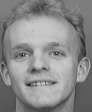

testing
[40.]


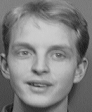

-------------------------------------
This face is correcctly classified to its class
training
[[24.]]


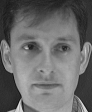

testing
[24.]


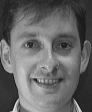

-------------------------------------
This face is correcctly classified to its class
training
[[16.]]


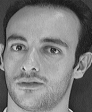

testing
[16.]


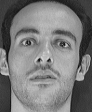

-------------------------------------
alpha = 0.8 accuracy:93.0%
This face is incorrecctly classified to a wrong class
training
[[38.]]


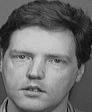

testing
[10.]


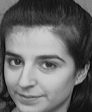

-------------------------------------
This face is correcctly classified to its class
training
[[24.]]


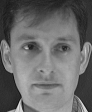

testing
[24.]


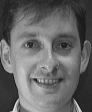

-------------------------------------
This face is correcctly classified to its class
training
[[26.]]


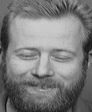

testing
[26.]


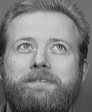

-------------------------------------
alpha = 0.85 accuracy:93.5%
This face is correcctly classified to its class
training
[[6.]]


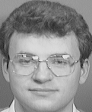

testing
[6.]


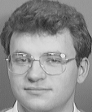

-------------------------------------
This face is correcctly classified to its class
training
[[7.]]


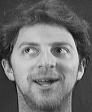

testing
[7.]


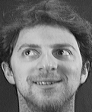

-------------------------------------
This face is correcctly classified to its class
training
[[29.]]


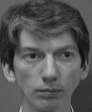

testing
[29.]


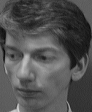

-------------------------------------
alpha = 0.9 accuracy:94.0%
This face is correcctly classified to its class
training
[[36.]]


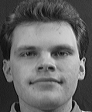

testing
[36.]


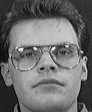

-------------------------------------
This face is correcctly classified to its class
training
[[7.]]


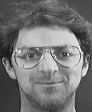

testing
[7.]


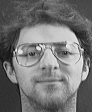

-------------------------------------
This face is correcctly classified to its class
training
[[30.]]


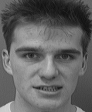

testing
[30.]


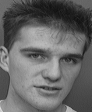

-------------------------------------
alpha = 0.95 accuracy:93.5%


In [ ]:
accuracy_PCA_R1 = KNN(1,projected_matrix_test_R1,projected_matrix_R1,training_labels,testing_labels) #First NN is KNN with k =1
print(f'alpha = 0.8 accuracy:{accuracy_PCA_R1}%')

accuracy_PCA_R2 = KNN(1,projected_matrix_test_R2,projected_matrix_R2,training_labels,testing_labels) #First NN is KNN with k =1
print(f'alpha = 0.85 accuracy:{accuracy_PCA_R2}%')

accuracy_PCA_R3 = KNN(1,projected_matrix_test_R3,projected_matrix_R3,training_labels,testing_labels) #First NN is KNN with k =1
print(f'alpha = 0.9 accuracy:{accuracy_PCA_R3}%')

accuracy_PCA_R4 = KNN(1,projected_matrix_test_R4,projected_matrix_R4,training_labels,testing_labels) #First NN is KNN with k =1
print(f'alpha = 0.95 accuracy:{accuracy_PCA_R4}%')

accuracy_PCA_R5 = KNN(1,projected_matrix_test_R5,projected_matrix_R5,training_labels_new,testing_labels_new) #First NN is KNN with k =1
print(f'alpha = 0.9 accuracy:{accuracy_PCA_R5}%')

Alpha vs Accuracy

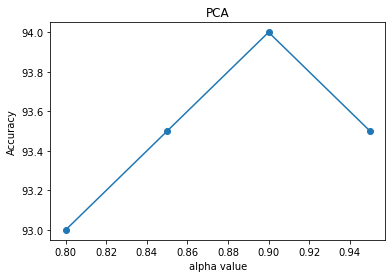

In [ ]:
alphas = [0.8, 0.85, 0.9, 0.95]
accuracy_PCA = [accuracy_PCA_R1, accuracy_PCA_R2, accuracy_PCA_R3, accuracy_PCA_R4]
plt.plot(alphas,accuracy_PCA,'-o')
plt.xlabel('alpha value')
plt.ylabel('Accuracy')
plt.title('PCA')
plt.show()

Classification using LDA

In [ ]:
eigen_vector_no = 39
start_LDA = time.time()
U_lda = LDA(training_set,training_labels,subjects_no,width,height,eigen_vector_no)
end_LDA = time.time()
runtime_LDA = end_LDA - start_LDA
print(runtime_LDA)

(10304, 10304)
520.5594136714935


LDA new

In [ ]:
eigen_vector_no = 39
U_lda_new = LDA(training_set_new,training_labels_new,subjects_no,width,height,eigen_vector_no)

(10304, 10304)


Pojection

In [ ]:
projected_matrix_lda = np.dot(Z,U_lda)
projected_matrix_test_lda = np.dot(Z_testing,U_lda)

Projection new

In [ ]:
projected_matrix_lda_new = np.dot(Z_new,U_lda_new)
projected_matrix_test_lda_new = np.dot(Z_testing_new,U_lda_new)

First-NN LDA

In [ ]:
accuracy_LDA = KNN(1,projected_matrix_test_lda,projected_matrix_lda,training_labels,testing_labels) # First-NN is KNN with k =1
print(f'Accuracy LDA : {accuracy_LDA}% ' )

Accuracy LDA : 95.5% 


First-NN LDA New

In [ ]:
accuracy_LDA_new = KNN(1,projected_matrix_test_lda_new,projected_matrix_lda_new,training_labels_new,testing_labels_new) # First-NN is KNN with k =1
print(f'Accuracy LDA New : {accuracy_LDA_new}% ' )

Accuracy LDA New : 95.0% 


K vs accuracy PCA , different alphas , and LDA

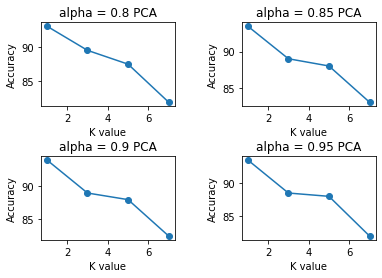

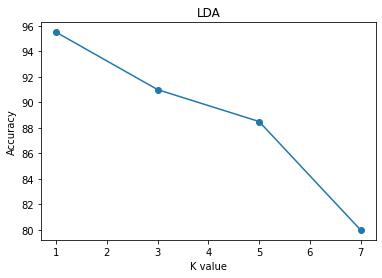

In [ ]:
ks = np.arange(1,8,2)
accuracy_alpha1 = []
accuracy_alpha2 = []
accuracy_alpha3 = []
accuracy_alpha4 = []
accuracy_LDA = []
for k in ks:
        
        accuracy_alpha1.append(KNN(k,projected_matrix_test_R1,projected_matrix_R1,training_labels,testing_labels))
        accuracy_alpha2.append(KNN(k,projected_matrix_test_R2,projected_matrix_R2,training_labels,testing_labels))
        accuracy_alpha3.append(KNN(k,projected_matrix_test_R3,projected_matrix_R3,training_labels,testing_labels))
        accuracy_alpha4.append(KNN(k,projected_matrix_test_R4,projected_matrix_R4,training_labels,testing_labels))
        accuracy_LDA.append(KNN(k,projected_matrix_test_lda,projected_matrix_lda,training_labels,testing_labels))
plt.subplot(2, 2, 1)
plt.subplots_adjust(wspace = 0.5, hspace = 0.6)
plt.plot(ks,accuracy_alpha1,'-o')
plt.xlabel('K value')
plt.ylabel('Accuracy')
plt.title('alpha = 0.8 PCA')
plt.subplot(2, 2, 2)
plt.plot(ks,accuracy_alpha2,'-o')
plt.xlabel('K value')
plt.ylabel('Accuracy')
plt.title('alpha = 0.85 PCA')
plt.subplot(2, 2, 3)
plt.plot(ks,accuracy_alpha3,'-o')
plt.xlabel('K value')
plt.ylabel('Accuracy')
plt.title('alpha = 0.9 PCA')
plt.subplot(2, 2, 4)
plt.plot(ks,accuracy_alpha4,'-o')
plt.xlabel('K value')
plt.ylabel('Accuracy')
plt.title('alpha = 0.95 PCA')
plt.show()
plt.plot(ks,accuracy_LDA,'-o')
plt.xlabel('K value')
plt.ylabel('Accuracy')
plt.title('LDA')
plt.show()


Comparing PCA of different alphas vs LDA

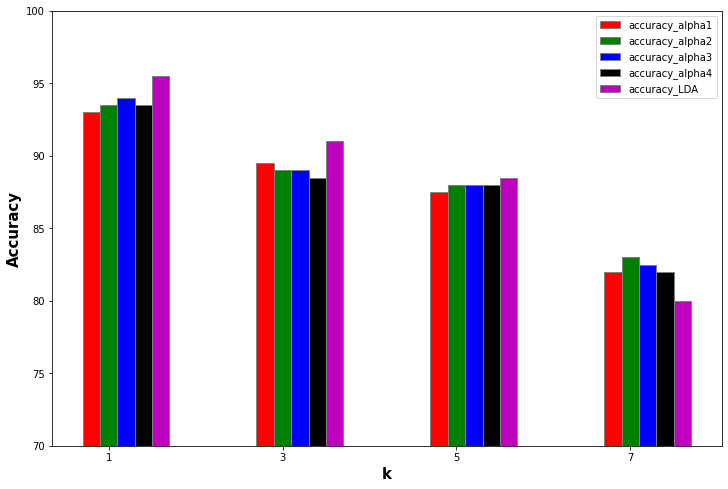

In [ ]:
barWidth = 0.1
fig = plt.subplots(figsize =(12, 8))
# Set position of bar on X axis
br1 = np.arange(len(ks ))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
 
# Make the plot
plt.bar(br1, accuracy_alpha1, color ='r', width = barWidth,
        edgecolor ='grey', label ='accuracy_alpha1')
plt.bar(br2, accuracy_alpha2, color ='g', width = barWidth,
        edgecolor ='grey', label ='accuracy_alpha2')
plt.bar(br3, accuracy_alpha3, color ='b', width = barWidth,
        edgecolor ='grey', label ='accuracy_alpha3')
plt.bar(br4, accuracy_alpha4, color ='k', width = barWidth,
        edgecolor ='grey', label ='accuracy_alpha4')
plt.bar(br5, accuracy_LDA, color ='m', width = barWidth,
        edgecolor ='grey', label ='accuracy_LDA')
 
# Adding Xticks
plt.xlabel('k', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracy', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(ks))],
        ['1', '3', '5', '7'])
plt.ylim(70, 100)
plt.legend()
plt.show()


Comparing PCA and LDA 50-50 split with 70-30 split

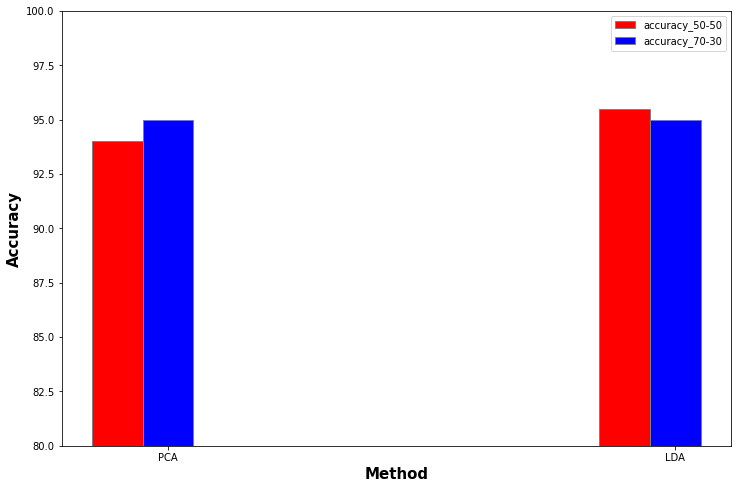

In [ ]:
barWidth = 0.1
fig = plt.subplots(figsize =(12, 8))
# Set position of bar on X axis
method=['PCA','LDA']
br1 = np.arange(len(method ))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
accuracies_50_50 = [accuracy_PCA_R3,accuracy_LDA[0]]
accuracies_70_30 = [accuracy_PCA_R5,accuracy_LDA_new]
# Make the plot
plt.bar(br1, accuracies_50_50, color ='r', width = barWidth,
        edgecolor ='grey', label ='accuracy_50-50')
plt.bar(br2, accuracies_70_30, color ='b', width = barWidth,
        edgecolor ='grey', label ='accuracy_70-30')

plt.xlabel('Method', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracy', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(method))],
        ['PCA', 'LDA'])
plt.legend()
plt.ylim(80, 100)
plt.show()

Compare Faces Vs Non-faces Images

Non-faces Adjustment

In [ ]:
# Load the CIFAR-10 dataset
(train_nf, train_labels_nf), (test_nf, test_labels_nf) = cifar10.load_data()
print(train_nf.shape)
random_indices_total = np.random.choice(test_nf.shape[0], 300, replace=False) 
train_nf = train_nf[random_indices_total]
test_nf = test_nf[random_indices_total]

(50000, 32, 32, 3)


Selecting a sample of 300 non-faces for training-testing datasets

In [ ]:
random_indices_300 = np.random.choice(test_nf.shape[0], 300, replace=False) 
train_nf_300 = train_nf[random_indices_300]
test_nf_300 = test_nf[random_indices_300]
train_non_faces_300,test_non_faces_300 = Prepare_non_faces(train_nf_300,test_nf_300)
print(train_non_faces_300)
print(test_non_faces_300.shape)

[[132 132 132 ... 128 128 128]
 [158 158 157 ... 160 160 160]
 [144 144 145 ...   8  10  11]
 ...
 [227 227 226 ... 220 223 224]
 [138 134 122 ... 129 135 137]
 [154 154 154 ...  92  90  89]]
(300, 10304)


In [ ]:
faces_nf_train_300 = np.concatenate((train_non_faces_300,training_set),axis=0)
faces_nf_test_300 = np.concatenate((test_non_faces_300,testing_set),axis=0)
zeros_300 = np.zeros(300)
ones_300 =  np.ones(200)
train_labels_f_nf_300 = np.concatenate((zeros_300,ones_300),axis=0)
test_labels_f_nf_300 = np.concatenate((zeros_300,ones_300),axis=0)
print(faces_nf_train_300.shape)
print(faces_nf_test_300.shape)

(500, 10304)
(500, 10304)


In [ ]:
eigen_faces_vector_300 ,Z_faces_300 , eigen_faces_values_300 = PCA(faces_nf_train_300)

(10304, 10304)
(10304, 10304)
True


In [ ]:
mean_testing_fnf_300 = faces_nf_test_300.mean(axis=0)
Z_faces_testing_300 = faces_nf_test_300 - mean_testing_fnf_300

In [ ]:
fnf_300=dimensions(0.9,eigen_faces_values_300)  #get numbers of dimensions for 90% accuracy
print(fnf_300)
Ur_faces_300 = eigen_faces_vector_300[:, 0 : fnf_300]  #choose only specified dimensions
projected_matrix_fnf_300 = np.dot(Z_faces_300,Ur_faces_300)  #project training data, with specified dimensions
projected_matrix_test_fnf_300 = np.dot(Z_faces_testing_300,Ur_faces_300) #project testing data
print(projected_matrix_fnf_300)

65
[[-1.69562440e+03 -1.19924039e+03 -3.21435034e+03 ...  4.39352577e+01
  -5.43110830e+01  8.40036042e+01]
 [ 2.67749484e+03  1.62917120e+03  3.35393540e+03 ... -3.44585152e+00
  -8.61669004e+01  2.51816754e+01]
 [-6.24656523e+03  5.94994327e+03  5.99103719e+02 ...  1.33078614e+02
  -1.44857231e+02  1.17418527e+02]
 ...
 [-2.35829374e+02 -8.84643912e+02  1.30416529e+03 ... -2.12900034e+02
   8.88006792e+01  1.43468254e+02]
 [-2.31102289e+02 -8.37530225e+02  1.55763840e+03 ... -3.20222326e+02
   7.83074291e+01  1.87398743e+02]
 [-2.31463480e+02 -5.43269799e+02  1.20832172e+03 ...  2.16359741e+01
  -1.08712355e+02 -1.41817586e+02]]


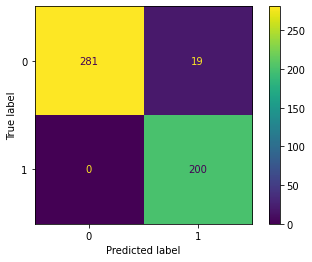

correctly classified as faces
training
[[1.]]


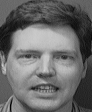

testing
[1.]


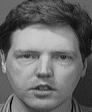

-------------------------------------
correctly classified as non-faces
training
[[1.]]


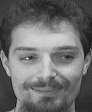

testing
[1.]


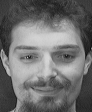

-------------------------------------
incorrectly classified as faces
training
[[1.]]


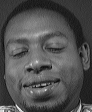

testing
[0.]


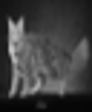

-------------------------------------
alpha = 0.9 accuracy:96.2%


In [ ]:
accuracy_PCA_fnf_300 = KNN(1,projected_matrix_test_fnf_300,projected_matrix_fnf_300,train_labels_f_nf_300,test_labels_f_nf_300,faces_nf_test_300,faces_nf_train_300) #First NN is KNN with k =1
print(f'alpha = 0.9 accuracy:{accuracy_PCA_fnf_300}%')

Binary LDA

In [ ]:
eigen_values_blda_300,eigen_vector_blda_300 = binary_LDA(faces_nf_train_300,train_labels_f_nf_300)

(10304, 1)
(10304, 10304)
(10304,)
(10304, 10304)


In [ ]:
dominant_eigen_values_no_300 = dimensions(0.9,np.diag(eigen_values_blda_300))
print(dominant_eigen_values_no_300)

1


Projection

In [ ]:
projected_matrix_lda_fnf_300 = np.dot(Z_faces_300,eigen_vector_blda_300[:,0:dominant_eigen_values_no_300])
projected_matrix_test_lda_fnf_300 = np.dot(Z_faces_testing_300,eigen_vector_blda_300[:,0:dominant_eigen_values_no_300])

F-NN faces vs non-faces

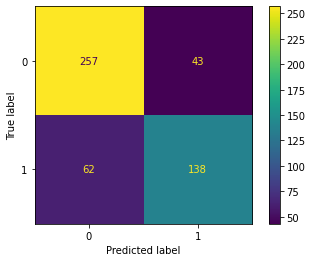

correctly classified as non-faces
training
[[0.]]


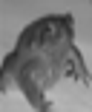

testing
[0.]


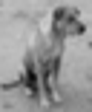

-------------------------------------
correctly classified as faces
training
[[1.]]


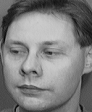

testing
[1.]


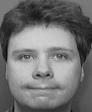

-------------------------------------
incorrectly classified as faces
training
[[1.]]


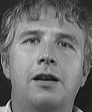

testing
[0.]


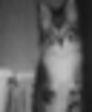

-------------------------------------
incorrectly classified as non-faces
training
[[0.]]


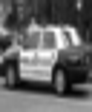

testing
[1.]


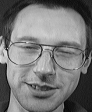

-------------------------------------
alpha = 0.9 accuracy:79.0%


In [ ]:
accuracy_LDA_fnf_300 = KNN(1,projected_matrix_test_lda_fnf_300,projected_matrix_lda_fnf_300,train_labels_f_nf_300,test_labels_f_nf_300,faces_nf_test_300,faces_nf_train_300) #First NN is KNN with k =1
print(f'alpha = 0.9 accuracy:{accuracy_LDA_fnf_300}%')

Selecting a sample of 250 non-faces for training-testing datasets

In [ ]:
random_indices_250 = np.random.choice(test_nf.shape[0], 250, replace=False) 
train_nf_250 = train_nf[random_indices_250]
test_nf_250 = test_nf[random_indices_250]
train_non_faces_250,test_non_faces_250 = Prepare_non_faces(train_nf_250,test_nf_250)
print(train_non_faces_250)
print(test_non_faces_250.shape)

[[144 144 144 ... 102 101 101]
 [187 186 185 ...  27  27  27]
 [ 63  58  48 ... 118 120 121]
 ...
 [164 163 160 ...  66  66  66]
 [ 46  48  54 ... 107 103 102]
 [ 81  82  86 ...  18  18  18]]
(250, 10304)


In [ ]:
faces_nf_train_250 = np.concatenate((train_non_faces_250,training_set),axis=0)
faces_nf_test_250 = np.concatenate((test_non_faces_250,testing_set),axis=0)
zeros_250 = np.zeros(250)
ones_250 =  np.ones(200)
train_labels_f_nf_250 = np.concatenate((zeros_250,ones_250),axis=0)
test_labels_f_nf_250 = np.concatenate((zeros_250,ones_250),axis=0)
print(faces_nf_train_250.shape)
print(faces_nf_test_250.shape)

(450, 10304)
(450, 10304)


In [ ]:
eigen_faces_vector_250 ,Z_faces_250 , eigen_faces_values_250 = PCA(faces_nf_train_250)

(10304, 10304)
(10304, 10304)
True


In [ ]:
mean_testing_fnf_250 = faces_nf_test_250.mean(axis=0)
Z_faces_testing_250 = faces_nf_test_250 - mean_testing_fnf_250

In [ ]:
fnf_250=dimensions(0.9,eigen_faces_values_250)  #get numbers of dimensions for 90% accuracy
print(fnf_250)
Ur_faces_250 = eigen_faces_vector_250[:, 0 : fnf_250]  #choose only specified dimensions
projected_matrix_fnf_250 = np.dot(Z_faces_250,Ur_faces_250)  #project training data, with specified dimensions
projected_matrix_test_fnf_250 = np.dot(Z_faces_testing_250,Ur_faces_250) #project testing data
print(projected_matrix_fnf_250)

64
[[ 1.72852298e+03  4.12309318e+02 -3.75097325e+02 ...  1.03154819e+01
  -6.95484752e+01 -2.83663441e+02]
 [-1.44228117e+03  9.20670922e+02 -5.82274094e+02 ... -3.07394731e+01
   9.34269671e+01  1.02923608e+02]
 [-4.85182690e+03 -1.21492565e+03  2.06530467e+03 ...  9.18565803e-01
  -1.60207873e+02  1.25031008e+01]
 ...
 [-2.87561178e+02 -8.82584880e+02 -1.18375353e+03 ...  1.73803580e+02
   2.04912632e+02  1.88198096e+02]
 [-2.87822056e+02 -8.36002002e+02 -1.44138490e+03 ... -3.13275522e+01
   2.23464807e+02  2.30480466e+02]
 [-2.48721670e+02 -5.69664304e+02 -1.07335601e+03 ... -3.91906062e+01
   6.99789010e+01  3.31655392e+02]]


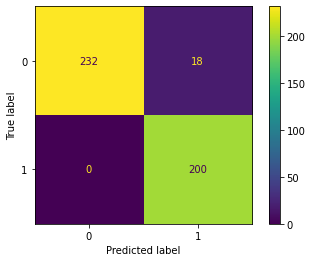

correctly classified as faces
training
[[1.]]


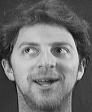

testing
[1.]


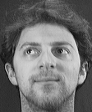

-------------------------------------
correctly classified as non-faces
training
[[1.]]


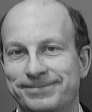

testing
[1.]


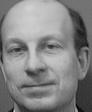

-------------------------------------
incorrectly classified as faces
training
[[1.]]


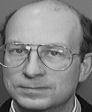

testing
[0.]


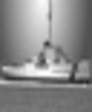

-------------------------------------
alpha = 0.9 accuracy:96.0%


In [ ]:
accuracy_PCA_fnf_250 = KNN(1,projected_matrix_test_fnf_250,projected_matrix_fnf_250,train_labels_f_nf_250,test_labels_f_nf_250,faces_nf_test_250,faces_nf_train_250) #First NN is KNN with k =1
print(f'alpha = 0.9 accuracy:{accuracy_PCA_fnf_250}%')

Binary LDA

In [ ]:
eigen_values_blda_250,eigen_vector_blda_250 = binary_LDA(faces_nf_train_250,train_labels_f_nf_250)

(10304, 1)
(10304, 10304)


In [ ]:
dominant_eigen_values_no_250 = dimensions(0.9,np.diag(eigen_values_blda_250))
print(dominant_eigen_values_no_250)

Projection

In [ ]:
projected_matrix_lda_fnf_250 = np.dot(Z_faces_250,eigen_vector_blda_250[:,0:dominant_eigen_values_no_250])
projected_matrix_test_lda_fnf_250 = np.dot(Z_faces_testing_250,eigen_vector_blda_250[:,0:dominant_eigen_values_no_250])

F-NN faces vs non-faces

In [ ]:
accuracy_LDA_fnf_250 = KNN(1,projected_matrix_test_lda_fnf_250,projected_matrix_lda_fnf_250,train_labels_f_nf_250,test_labels_f_nf_250,faces_nf_test_250,faces_nf_train_250) #First NN is KNN with k =1
print(f'alpha = 0.9 accuracy:{accuracy_LDA_fnf_250}%')

Selecting a sample of 200 non-faces for 50%-50% training-testing datasets

In [ ]:
random_indices = np.random.choice(test_nf.shape[0], 200, replace=False) 
train_nf = train_nf[random_indices]
test_nf = test_nf[random_indices]
train_non_faces,test_non_faces = Prepare_non_faces(train_nf,test_nf)
print(train_non_faces)
print(test_non_faces.shape)

Merging faces and non-faces in a single dataset

In [ ]:
faces_nf_train = np.concatenate((train_non_faces,training_set),axis=0)
faces_nf_test = np.concatenate((test_non_faces,testing_set),axis=0)
zeros = np.zeros(200)
ones =  np.ones(200)
train_labels_f_nf = np.concatenate((zeros,ones),axis=0)
test_labels_f_nf = np.concatenate((zeros,ones),axis=0)
print(faces_nf_train.shape)
print(faces_nf_test.shape)

(400, 10304)
(400, 10304)


PCA for faces vs non-faces classification

In [ ]:
eigen_faces_vector ,Z_faces , eigen_faces_values= PCA(faces_nf_train)

(10304, 10304)
(10304, 10304)
True


Center testing data

In [ ]:
mean_testing_fnf = faces_nf_test.mean(axis=0)
Z_faces_testing = faces_nf_test - mean_testing_fnf

Projection

In [ ]:
fnf=dimensions(0.9,eigen_faces_values)  #get numbers of dimensions for 90% accuracy
print(fnf)
Ur_faces = eigen_faces_vector[:, 0 : fnf]  #choose only specified dimensions
projected_matrix_fnf = np.dot(Z_faces,Ur_faces)  #project training data, with specified dimensions
projected_matrix_test_fnf = np.dot(Z_faces_testing,Ur_faces) #project testing data
print(projected_matrix_fnf)


65
[[  408.24127122 -1906.21934438 -1713.6628803  ...   -48.46902662
   -121.43746472     5.53114915]
 [ 2486.29277445  3106.73165623   852.07508351 ...  -228.56986332
   -125.5364973    -97.76279807]
 [  818.70955862   109.19950543 -1601.41504504 ...   -25.34908969
     27.93336756   -42.1873359 ]
 ...
 [   71.52562528  -856.01367408  1071.25128537 ...   170.92191868
    183.22959814  -289.87698819]
 [   67.71066271  -821.44489945  1325.35363716 ...   310.43846357
     -9.42403248  -428.57144841]
 [   82.24697791  -491.50561194  1046.0663726  ...  -213.26297743
   -357.16006995  -221.99028657]]


F-NN PCA Face vs Non-faces

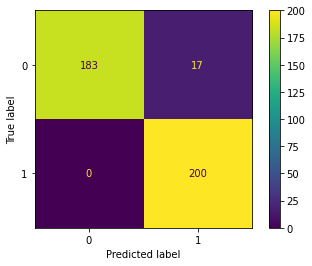

correctly classified as non-faces
training
[[0.]]


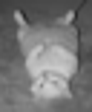

testing
[0.]


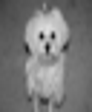

-------------------------------------
correctly classified as faces
training
[[1.]]


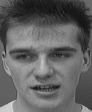

testing
[1.]


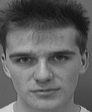

-------------------------------------
incorrectly classified as faces
training
[[1.]]


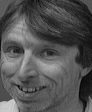

testing
[0.]


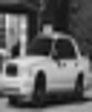

-------------------------------------
alpha = 0.9 accuracy:95.75%


In [ ]:
accuracy_PCA_fnf = KNN(1,projected_matrix_test_fnf,projected_matrix_fnf,train_labels_f_nf,test_labels_f_nf,faces_nf_test,faces_nf_train) #First NN is KNN with k =1
print(f'alpha = 0.9 accuracy:{accuracy_PCA_fnf}%')


Binary LDA for faces vs non-faces

In [ ]:
eigen_values_blda,eigen_vector_blda = binary_LDA(faces_nf_train,train_labels_f_nf)

In [ ]:
dominant_eigen_values_no = dimensions(0.9,np.diag(eigen_values_blda))
print(dominant_eigen_values_no)

Projection

In [ ]:
projected_matrix_lda_fnf = np.dot(Z_faces,eigen_vector_blda[:,0:dominant_eigen_values_no])
projected_matrix_test_lda_fnf = np.dot(Z_faces_testing,eigen_vector_blda[:,0:dominant_eigen_values_no])

F-NN faces vs non-faces

In [ ]:
accuracy_LDA_fnf = KNN(1,projected_matrix_test_lda_fnf,projected_matrix_lda_fnf,train_labels_f_nf,test_labels_f_nf,faces_nf_test,faces_nf_train) #First NN is KNN with k =1
print(f'alpha = 0.9 accuracy:{accuracy_LDA_fnf}%')

Selecting a sample of 150 non-faces for training-testing datasets

In [ ]:
random_indices_150 = np.random.choice(test_nf.shape[0], 150, replace=False) 
train_nf_150 = train_nf[random_indices_150]
test_nf_150 = test_nf[random_indices_150]
train_non_faces_150,test_non_faces_150 = Prepare_non_faces(train_nf_150,test_nf_150)
print(train_non_faces_150)
print(test_non_faces_150.shape)

[[122 122 123 ...  92  89  88]
 [144 144 144 ... 136 135 135]
 [242 241 239 ... 119 119 119]
 ...
 [164 166 172 ...   4   3   3]
 [216 216 215 ... 127 128 128]
 [131 131 131 ... 157 158 158]]
(150, 10304)


In [ ]:
faces_nf_train_150 = np.concatenate((train_non_faces_150,training_set),axis=0)
faces_nf_test_150 = np.concatenate((test_non_faces_150,testing_set),axis=0)
zeros_150 = np.zeros(150)
ones_150 =  np.ones(200)
train_labels_f_nf_150 = np.concatenate((zeros_150,ones_150),axis=0)
test_labels_f_nf_150 = np.concatenate((zeros_150,ones_150),axis=0)
print(faces_nf_train_150.shape)
print(faces_nf_test_150.shape)

(350, 10304)
(350, 10304)


In [ ]:
eigen_faces_vector_150 ,Z_faces_150 , eigen_faces_values_150 = PCA(faces_nf_train_150)

(10304, 10304)
(10304, 10304)
True


In [ ]:
mean_testing_fnf_150 = faces_nf_test_150.mean(axis=0)
Z_faces_testing_150 = faces_nf_test_150 - mean_testing_fnf_150

In [ ]:
fnf_150=dimensions(0.9,eigen_faces_values_150)  #get numbers of dimensions for 90% accuracy
print(fnf_150)
Ur_faces_150 = eigen_faces_vector_150[:, 0 : fnf_150]  #choose only specified dimensions
projected_matrix_fnf_150 = np.dot(Z_faces_150,Ur_faces_150)  #project training data, with specified dimensions
projected_matrix_test_fnf_150 = np.dot(Z_faces_testing_150,Ur_faces_150) #project testing data
print(projected_matrix_fnf_150)

66
[[  -98.1243339    649.6317996   1453.79105449 ...   307.87570066
   -187.33760597   121.63417961]
 [-4355.82431414   -38.36293594  2621.46772733 ...    53.85546555
    -19.37384941   -52.10187156]
 [ -234.02281136  3407.52625717 -2382.6608183  ...   157.8688499
    -38.50145947  -505.68145759]
 ...
 [ -115.89765727  -928.95582996   716.60219182 ...   276.21125765
    -33.83648643   197.39915874]
 [ -105.22284126  -947.30463626   981.51948007 ...    38.1180554
   -150.60243034   207.64505215]
 [ -100.27699867  -569.23210105   802.38048308 ...  -156.67703457
    -80.66680424  -177.11152788]]


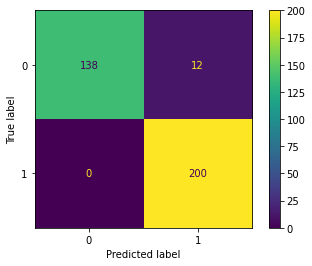

correctly classified as faces
training
[[1.]]


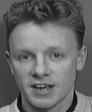

testing
[1.]


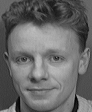

-------------------------------------
correctly classified as non-faces
training
[[1.]]


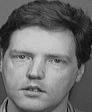

testing
[1.]


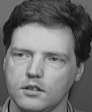

-------------------------------------
incorrectly classified as faces
training
[[1.]]


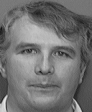

testing
[0.]


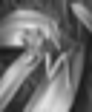

-------------------------------------
alpha = 0.9 accuracy:96.57142857142857%


In [ ]:
accuracy_PCA_fnf_150 = KNN(1,projected_matrix_test_fnf_150,projected_matrix_fnf_150,train_labels_f_nf_150,test_labels_f_nf_150,faces_nf_test_150,faces_nf_train_150) #First NN is KNN with k =1
print(f'alpha = 0.9 accuracy:{accuracy_PCA_fnf_150}%')

Binary LDA

In [ ]:
eigen_values_blda_150,eigen_vector_blda_150 = binary_LDA(faces_nf_train_150,train_labels_f_nf_150)

In [ ]:
dominant_eigen_values_no_150 = dimensions(0.9,np.diag(eigen_values_blda_150))
print(dominant_eigen_values_no_150)

Projection

In [ ]:
projected_matrix_lda_fnf_150 = np.dot(Z_faces_150,eigen_vector_blda_150[:,0:dominant_eigen_values_no_150])
projected_matrix_test_lda_fnf_150 = np.dot(Z_faces_testing_150,eigen_vector_blda_150[:,0:dominant_eigen_values_no_150])

F-NN faces vs non-faces

In [ ]:
accuracy_LDA_fnf_150 = KNN(1,projected_matrix_test_lda_fnf_150,projected_matrix_lda_fnf_150,train_labels_f_nf_150,test_labels_f_nf_150,faces_nf_test_150,faces_nf_train_150) #First NN is KNN with k =1
print(f'alpha = 0.9 accuracy:{accuracy_LDA_fnf_150}%')

Accuracy vs Number of non faces images 

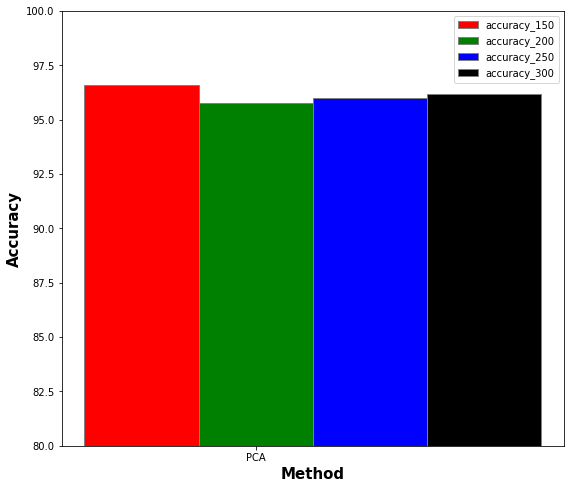

In [ ]:
barWidth = 0.1
fig = plt.subplots(figsize =(9, 8))
# Set position of bar on X axis
method=['PCA']
br1 = np.arange(len(method ))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

# Make the plot
plt.bar(br1, accuracy_PCA_fnf_150, color ='r', width = barWidth,
        edgecolor ='grey', label ='accuracy_150')
plt.bar(br2, accuracy_PCA_fnf, color ='g', width = barWidth,
        edgecolor ='grey', label ='accuracy_200')
plt.bar(br3, accuracy_PCA_fnf_250, color ='b', width = barWidth,
        edgecolor ='grey', label ='accuracy_250')
plt.bar(br4, accuracy_PCA_fnf_300, color ='k', width = barWidth,
        edgecolor ='grey', label ='accuracy_300')
plt.xlabel('Method', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracy', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(method))],
        ['PCA'])
plt.legend()
plt.ylim(80, 100)
plt.show()

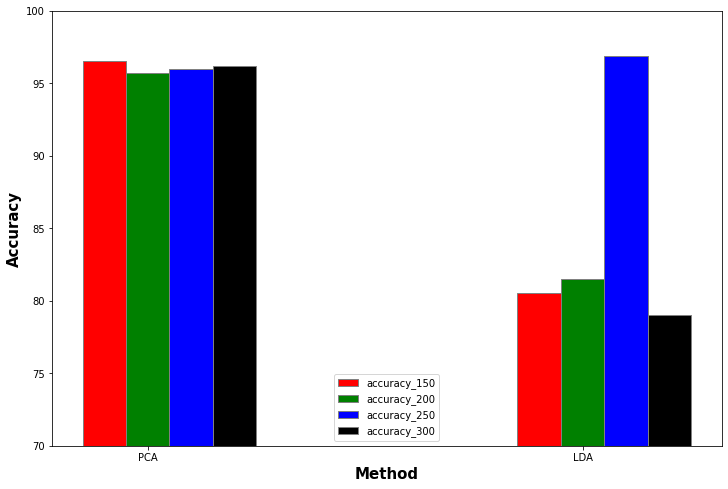

In [ ]:
barWidth = 0.1
fig = plt.subplots(figsize =(12, 8))
# Set position of bar on X axis
method=['PCA','LDA']
br1 = np.arange(len(method ))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
accuracies_300 = [96.2, 79.0]
accuracies_250 = [96.0,96.88888888888889]
accuracies_200 = [95.75,81.5]
accuracies_150 = [96.57142857142857,80.57142857142857]
#accuracies_150 = [accuracy_PCA_fnf_150,accuracy_LDA_fnf_150 ]
#accuracies_200 = [accuracy_PCA_fnf,accuracy_LDA_fnf ]
#accuracies_250 = [accuracy_PCA_fnf_250,accuracy_LDA_fnf_250 ]
#accuracies_300 = [accuracy_PCA_fnf_300,accuracy_LDA_fnf_300 ]
# Make the plot
plt.bar(br1, accuracies_150, color ='r', width = barWidth,
        edgecolor ='grey', label ='accuracy_150')
plt.bar(br2, accuracies_200, color ='g', width = barWidth,
        edgecolor ='grey', label ='accuracy_200')
plt.bar(br3, accuracies_250, color ='b', width = barWidth,
        edgecolor ='grey', label ='accuracy_250')
plt.bar(br4, accuracies_300, color ='k', width = barWidth,
        edgecolor ='grey', label ='accuracy_300')
plt.xlabel('Method', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracy', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(method))],
        ['PCA','LDA'])
plt.legend()
plt.ylim(70, 100)
plt.show()

Kernel PCA

In [ ]:
start_kernel = time.time()
U_kernel , Z_kernel , eigen_values_kernel = kernel_pca(training_set,1/(width*height)) #gamma =  1/no. of features
end_kernel = time.time()
runtime_kernel = end_kernel - start_kernel
print(runtime_kernel)
U_test_kernel , Z_test_kernel , eigen_values_test_kernel = kernel_pca(testing_set,1/(width*height)) #gamma =  1/no. of features

(200, 200)
(200,)
0.061191558837890625
(200, 200)
(200,)


In [ ]:
kernel_dimensions=dimensions(0.9,eigen_values_kernel)
print(kernel_dimensions)
projected_matrix_kernel = U_kernel[:, 0 : kernel_dimensions]

projected_matrix_test_kernel = U_test_kernel[:, 0 : kernel_dimensions]

180


F-NN Kernel PCA , First NN is KNN with k =1

In [ ]:
accuracy_kernel = KNN(1,projected_matrix_test_kernel,projected_matrix_kernel,training_labels,testing_labels) #First NN is KNN with k =1
print(f'alpha = 0.9 accuracy:{accuracy_kernel}%')


alpha = 0.9 accuracy:100.0%


Regularized LDA

In [37]:
start_regularized_LDA = time.time()
alpha = 0.25
U_regularized_LDA,eigen_values_regularized_LDA = regularized_LDA(training_set, training_labels, subjects_no, width, height, alpha)
end_regularized_LDA = time.time()
runtime_regularized_LDA = end_regularized_LDA - start_regularized_LDA
print(runtime_regularized_LDA)

563.5903015136719


In [42]:
eigen_values_regularized_LDA_no = dimensions(0.9,np.diag(eigen_values_regularized_LDA))
print(eigen_values_regularized_LDA_no)

5


In [39]:
U_regularized_LDA = U_regularized_LDA[:,0: eigen_values_regularized_LDA_no]

Projection

In [40]:
projected_matrix_regularized_LDA = np.dot(Z,U_regularized_LDA)
projected_matrix_test_regularized_LDA = np.dot(Z_testing,U_regularized_LDA)

F-NN Regularized LDA

This face is correctly classified to its class
training
[[28.]]


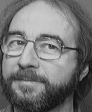

testing
[28.]


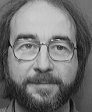

-------------------------------------
This face is correctly classified to its class
training
[[7.]]


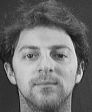

testing
[7.]


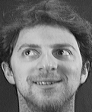

-------------------------------------
This face is correctly classified to its class
training
[[36.]]


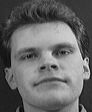

testing
[36.]


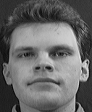

-------------------------------------
alpha = 0.9 accuracy:90.5%


In [41]:
accuracy_regularized_LDA = KNN(1,projected_matrix_test_regularized_LDA,projected_matrix_regularized_LDA,training_labels,testing_labels) #First NN is KNN with k =1
print(f'alpha = 0.9 accuracy:{accuracy_regularized_LDA}%')